In [1]:
import tike
import dxchange
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tike.constants import *
import pickle
import lzma

# Setup Experiment

## Probe

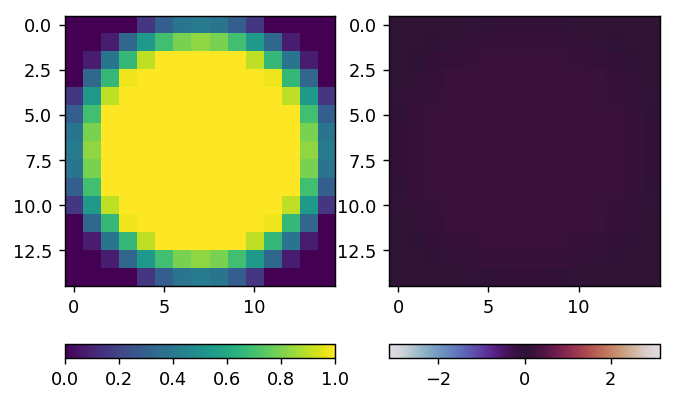

0j (0.9800666+0.19866933j)


In [2]:
# Create a probe.
pw = 15 # probe width
energy = 5 # keV probe energy
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
tike.plot_phase(probe)

## Object

In [3]:
# Load a 3D object.
with lzma.open('../tests/data/nalm256.pickle.lzma', 'rb') as file:
    obj = pickle.load(file)[::4, ::4, ::4]
obj.shape

(64, 64, 64)

In [4]:
np.min(obj), np.max(obj)

(0j, (0.00013467284535695345+2.7094510719149577e-05j))

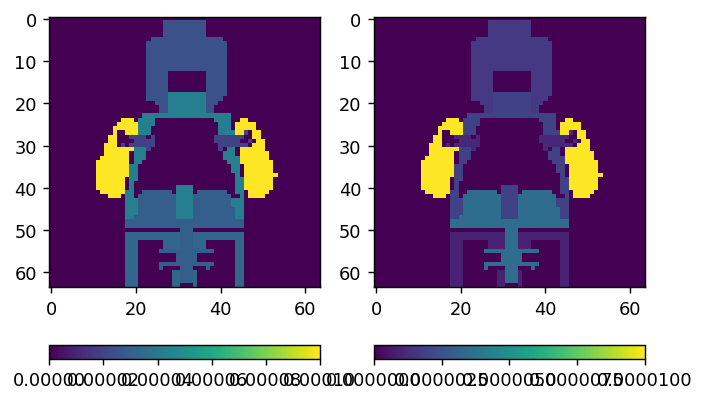

In [5]:
# Assemble the object.
voxelsize = 1e-7 * 4
tike.plot_complex(obj[:, len(obj)//2, :], rmax=1e-4, imax=1e-5)

## Trajectory

In [6]:
N_ANGLE = int(np.pi / 2 * obj.shape[2])
theta = np.linspace(0, np.pi, N_ANGLE, endpoint=False)
theta.shape

(100,)

In [7]:
none, v, h = np.meshgrid(np.arange(N_ANGLE),
                   np.arange(0, obj.shape[0]-pw, pw//2,),
                   np.arange(0, obj.shape[2]-pw, pw//2,),
                   indexing='ij')
print(h.shape)

(100, 7, 7)


# Simulate data

In [8]:
data = tike.simulate(obj=obj, voxelsize=voxelsize,
                     probe=probe, theta=theta, v=v, h=h, energy=energy,
                     detector_shape=(pw*3, pw*3))

INFO:tike.communicator:Node 0 is running.


In [9]:
np.array(data).shape

(100, 49, 45, 45)

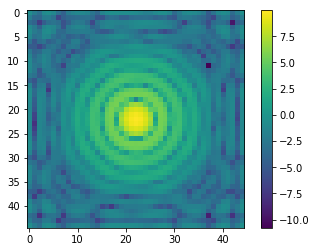

(1.3583740925378771e-09, 21373.817996649374)

In [10]:
plt.imshow(np.fft.fftshift(np.log(data[16][16])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

In [11]:
# init = np.random.rand(*obj.shape, 2).view(complex)[..., 0]
recon = np.zeros(obj.shape, dtype=complex)
recon.shape

(64, 64, 64)

In [12]:
recon = tike.admm(obj=recon, voxelsize=voxelsize,
             data=data,
             probe=probe, theta=theta, v=v, h=h, energy=energy,
             niter=20,
             rho=0.5, gamma=0.25,
            )

INFO:tike.communicator:Node 0 is running.
INFO:tike.tike:ADMM iteration 0


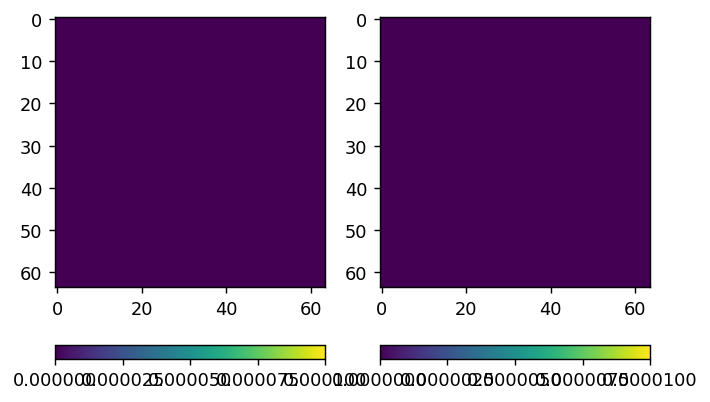

In [13]:
tike.plot_complex(recon[:, len(recon)//2, :], rmax=1e-4, imax=1e-5)